# Setup

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os
from utils.char_tokenizer import CharTokenizer

In [2]:
config = json.load(open("config.json"))

# Loading data

In [3]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data['product_type'] = data['product_type.value']
data = data[['description', 'description2', 'path', 'product_type', 'label']]
data

,description,description2,path,product_type,label
0,mobile coverb075yysthnamazon brand - solimo de...,"mobile coverb08563mwp6365 everyday value, psyl...",d1/d1092873.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07t6v3t9samazon brand - solimo de...,meal kitsb0748r4spcamazon brand - solimo desig...,25/25c3cc65.jpg,SOFA,0
2,mobile coverb081hncfc3amazon brand - solimo de...,mobile coverb081hncfc3amazon brand - solimo de...,5a/5a18d1b1.jpg,CELLULAR_PHONE_CASE,1
3,pinzonb07k97dsjxamazon brand - the fix women's...,air freshener for bathroomb07ydqrzkfamazon bra...,bf/bf853367.jpg,CELLULAR_PHONE_CASE,0
4,mobile coverb0853wz9vvamazon brand - solimo de...,shoesb00r7neg2qamazon-merk: solimo - sun – aft...,c1/c1820404.jpg,BEAUTY,0
...,...,...,...,...,...
157051,back coverb07tg4894famazon brand - symbol men'...,expandingb074mgjzy9amazon brand - solimo desig...,08/0836e89c.jpg,CELLULAR_PHONE_CASE,0
157052,bed;gift;tent;plushie;hands;foam;year;figures;...,mobile coverb08dxd2qcv[amazonブランド] umi.(ウミ)窓用ガ...,2b/2b762611.jpg,HOME_FURNITURE_AND_DECOR,0
157053,samsung galaxy m31 mobile caseb085119c3mamazon...,samsung galaxy m31 mobile caseb085119c3mamazon...,61/61677d34.jpg,CELLULAR_PHONE_CASE,1
157054,luminaidb07x2tgp2mamazon brand - solimo design...,back coverb07tc4plxmwickedly prime organic spr...,a9/a981baf8.jpg,CELLULAR_PHONE_CASE,0


In [4]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Tokenize texts

In [5]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(157056, 1014)

# Create embedding weights

In [6]:
weights = tk.create_embedding_weights()
weights.shape

(3202, 3201)

# Save Char CNN config

In [7]:
from models.char_cnn_zhang import CharCNNZhang

In [8]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fully_connected_layers": config["char_cnn_zhang"]["fully_connected_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [9]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Load MNN-EM Model

In [10]:
from models.mnn_em import MNNEM

In [11]:
model = MNNEM(img_input_size=2048,      # placeholder value
              img_conv_layers=config["mnn_em"]["img_conv_layers"],
              txt_input_size=config["data"]["input_size"],
              txt_conv_layers=config["mnn_em"]["txt_conv_layers"],
              txt_weights=weights,
              char_cnn_config=char_cnn_config,
              combined_conv_layers=config["mnn_em"]["combined_conv_layers"],
              learning_rate=config["mnn_em"]["learning_rate"]
              )

In [12]:
model.model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 Character_Level_CNN (Functiona  (None, 2048)        29295234    ['Text_Input[0][0]']             
 l)                                                                                               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| sent_input (InputLayer)      [(None, 1014)]       0           []                            

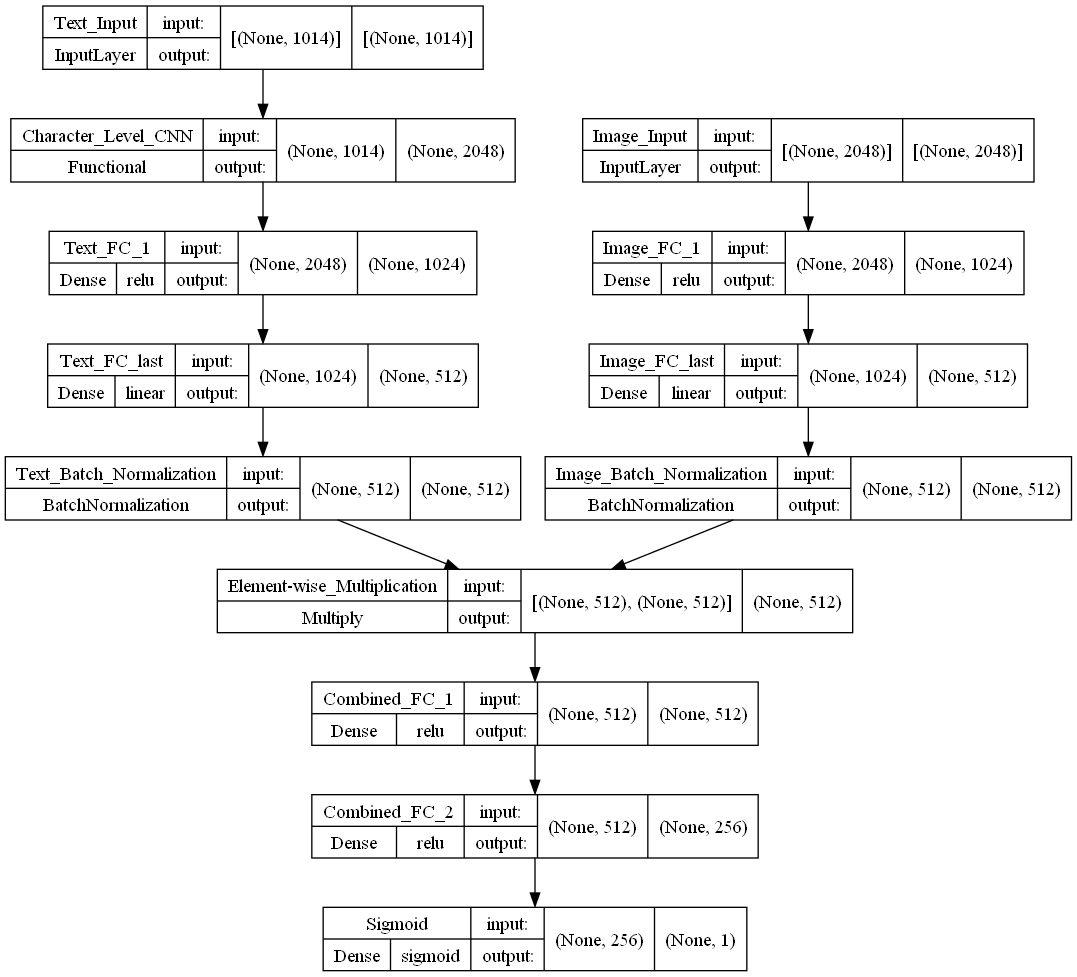

In [13]:
tf.keras.utils.plot_model(model.model, rankdir="TB", show_layer_activations=True, show_shapes=True)